check if there's available gpu

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ## maybe i don't need it
import tensorflow as tf
import time
import datetime
import torch

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig


In [2]:
%%capture
!pip install transformers

In [3]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print(f'Found GPU at: {(device_name)}')

else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


set our gpu as the device.

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


load data

i'm using this one `https://www.kaggle.com/competitions/nlp-getting-started/data` from kaggle.

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Coder/Scripts/365 Days Of Bert/Day22/Data/train.csv')
validation = pd.read_csv('/content/drive/MyDrive/Coder/Scripts/365 Days Of Bert/Day22/Data/test.csv')

## see data
train.sample(10)

,id,keyword,location,text,target
4699,6681,landslide,NaN,being stuck on a sleeper train for 24 hours af...,1
1341,1939,burning%20buildings,NaN,#KCA #VoteJKT48ID DUCKVILLELOL: Burning flips ...,0
243,346,annihilation,"California, USA",@rvfriedmann Hell is just a fraction of his be...,1
12,18,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1
2655,3814,detonate,"Morioh, Japan",@spinningbot Are you another Stand-user? If yo...,0
3737,5310,fear,USA,Daily Reflections\nAugust 6\nDRIVEN\nDriven by...,0
784,1136,blight,London,Poor Jack ??,0
257,365,annihilation,NaN,@willienelson We need help! Horses will die!Pl...,1
3940,5602,flood,NaN,survived the plague\nfloated the flood\njust p...,0
7093,10159,violent%20storm,UK,Terrifying POV footage captures violent landin...,1


delete others columns

In [7]:
train_simple = train[['text', 'target']]
validation_simple = validation[['text']]

In [8]:
train_simple.sample(10)

,text,target
2806,RT @AmznFavorites THE DEVEREAUX DISASTER. 'Exc...,0
7162,Sundays during football seasonfrom about 9 am ...,0
3813,Loved the way this book was written to include...,0
6166,Reasons I should have gone to Warped today: to...,1
7308,Wild fires freak me the fuck out. Like hell no,1
6205,I want to smoke ??,0
5624,@ViralSpell: 'Couple spend wedding day feeding...,0
43,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0
1924,INFO S. WND: 030/6. CLD: SCT014 BKN032. EXP IN...,0
1495,Success is not built on success. Its built on ...,0


In [16]:
# train.target.value_counts()

get labels and text

In [9]:
sentences = train_simple.text.values
labels = train_simple.target.values

transforming data in a format that bert "understand".

huh: `do_lower_case=True` why?

In [20]:
%%capture

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, )
# tokenizer

tokenizer playground

In [21]:
# Print the original sentence.
print('Teste: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Teste:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


notice that in token IDs we don't have the "special" tokens that bert needs.

* trucation -> cut off
* padding -> adding

why? words to be the same size.

In [31]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [32]:
%%capture

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [26]:
# print('Original: ', sentences[0])

In [27]:
# print('Token IDs:', input_ids[0])

Big Aha: Attention help us differ real words from padding or truncation.

Split Data

In [34]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,851 training samples
  762 validation samples


In [36]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [39]:
%%capture
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The papers's author rec use those parameters.

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [41]:
%%capture

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [49]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [50]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [51]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

train

In [52]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    215.    Elapsed: 0:00:21.
  Batch    80  of    215.    Elapsed: 0:00:42.
  Batch   120  of    215.    Elapsed: 0:01:03.
  Batch   160  of    215.    Elapsed: 0:01:23.
  Batch   200  of    215.    Elapsed: 0:01:43.

  Average training loss: 0.27
  Training epcoh took: 0:01:51

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.60
  Validation took: 0:00:04

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    215.    Elapsed: 0:00:21.
  Batch    80  of    215.    Elapsed: 0:00:42.
  Batch   120  of    215.    Elapsed: 0:01:02.
  Batch   160  of    215.    Elapsed: 0:01:23.
  Batch   200  of    215.    Elapsed: 0:01:43.

  Average training loss: 0.20
  Training epcoh took: 0:01:51

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.60
  Validation took: 0:00:04

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    215.    Elapsed: 0:00:21.
  Batch    80  of    215.    Elapsed: 0:00:41.
 

In [53]:
# Display floats with two decimal places.
pd.options.display.precision = 2

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.27,0.60,0.78,0:01:51,0:00:04
2,0.20,0.60,0.80,0:01:51,0:00:04
3,0.17,0.63,0.81,0:01:51,0:00:04


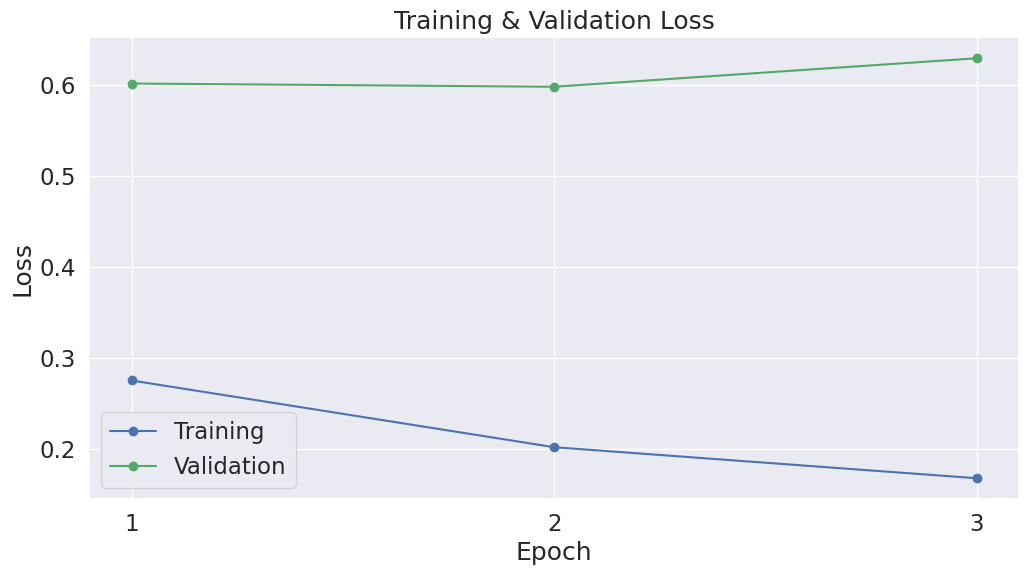

In [54]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [55]:
model.save_pretrained("day22")
tokenizer.save_pretrained("day22")

('day22/tokenizer_config.json',
 'day22/special_tokens_map.json',
 'day22/vocab.txt',
 'day22/added_tokens.json')

In [56]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "/content/day22"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [58]:
texts = validation["text"].tolist()

In [59]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=100)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}


from torch.utils.data import DataLoader, TensorDataset

# Criar dataset PyTorch
test_dataset = TensorDataset(inputs["input_ids"], inputs["attention_mask"])

# Criar DataLoader com batch size menor
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {key: val.to(device) for key, val in zip(["input_ids", "attention_mask"], batch)}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(preds)

In [62]:
sub = pd.read_csv("/content/sample_submission.csv")

sub['target'] = predictions
sub.to_csv("sub.csv", index=False)